In [1]:
import postprocess
import plot
import QuasinormalMode
import spheroidal

from postprocess import *
from plot import *
from QuasinormalMode import *
from spheroidal import *

2023-03-27 11:12:05.224577: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-03-27 11:12:05.282925: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-03-27 11:12:05.288025: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIB

In [2]:
from importlib import reload

In [3]:
reload(postprocess)
from postprocess import *
reload(plot)
from plot import *
reload(QuasinormalMode) 
from QuasinormalMode import *
reload(spheroidal)
from spheroidal import *

In [4]:
import pandas as pd
from matplotlib import ticker 

In [5]:
def linfunc(p, x):
    m, c= p
    return m * x + c 

def linfunc2(p, x):
    c = p
    return 2*x + c 

In [6]:
def is_quadratic(row):
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return False
    lmnx = str_to_lmnx(mode_string)
    if len(lmnx) == 2:
        return True
    else:
        return False
    
def is_overtone(row):
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return False
    lmnx = str_to_lmnx(mode_string)
    for lmn in lmnx:
        l, m, n = tuple(lmn)
        if n > 0:
            return True
    return False

def is_fundamental(row):
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return False
    lmnx = str_to_lmnx(mode_string)
    if len(lmnx) == 1 and lmnx[0][2] == 0:
        return True
    else:
        return False

# def is_mixing(row):
#     l_harm = row['l']
#     m_harm = row['m']
#     mode_string = row['mode_string']
#     if mode_string == 'constant':
#         return False
#     lmnx = str_to_lmnx(mode_string)
#     l_sum, m_sum = lmnx_sum_lm(lmnx)
#     if l_sum != l_harm and abs(m_sum) == m_harm:
#         return True
#     else:
#         return False
    
def harm_type(row):
    l_harm = row['l']
    m_harm = row['m']
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return 'constant'
    lmnx = str_to_lmnx(mode_string)
    l_sum, m_sum = lmnx_sum_lm(lmnx)
    if l_sum == l_harm and abs(m_sum) == m_harm:
        return 'basic'
    elif l_sum != l_harm and abs(m_sum) == m_harm:
        return 'mixing'
    else:
        return 'recoil'


def is_retro(row):
    retro = row['retro']
    if retro:
        retrofac = -1
    else:
        retrofac = 1
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return False
    lmnx = str_to_lmnx(mode_string)
    _, m_sum = lmnx_sum_lm(lmnx)
    if m_sum*retrofac < 0:
        return True
    else:
        return False


def natural_m(row):
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return -1
    lmnx = str_to_lmnx(mode_string)
    _, m_sum = lmnx_sum_lm(lmnx)
    return abs(m_sum)

def natural_l(row):
    mode_string = row['mode_string']
    if mode_string == 'constant':
        return -1
    lmnx = str_to_lmnx(mode_string)
    l_sum, _ = lmnx_sum_lm(lmnx)
    return l_sum


In [7]:
settingname = "normal2"
df = pd.read_csv(f"./pickle/data_frame/{settingname}.csv")

In [46]:
def sym_mass_ratio(row):
    q = row['q']
    return q/(1 + q)**2

In [8]:
df_0305 = df[df['SXS_num'] == 305]

In [ ]:
def classify_modes(df):
    col_quad = df.apply(is_quadratic, axis = 1)
    col_fund = df.apply(is_fundamental, axis = 1)
    col_over = df.apply(is_overtone, axis = 1)
    col_retro = df.apply(is_retro, axis = 1)
    col_type = df.apply(harm_type, axis = 1)
    col_nat_l = df.apply(natural_l, axis = 1)
    col_nat_m = df.apply(natural_m, axis = 1)
    col_eta = df.apply(sym_mass_ratio, axis = 1)
    df = df.assign(eta=col_eta.values,
                is_quadratic=col_quad.values,
                is_fundamental=col_fund.values,
                is_overtone=col_over.values,
                is_retrograde=col_retro.values,
                harm_type=col_type.values,
                natural_l=col_nat_l.values,
                natural_m=col_nat_m.values)
    return df

In [10]:
df = classify_modes(df)

In [11]:
pd.set_option('display.max_rows', None)
df_overtones = df[df['is_overtone'] == True]
# df_dup_over = df_overtones[df_overtones.duplicated(subset=['SXS_num', 'l', 'm', 'is_overtone'], keep=False)]
df_dup_over = df_overtones

In [12]:
df_sus_over = df_dup_over[df_dup_over['harm_type'] != 'basic']
sus_overs = df_sus_over.loc[:, ['SXS_num', 'mode_string', 'natural_l', 'natural_m']]
sus_overs_should_be = sus_overs.rename(columns={'natural_l': 'l', 'natural_m': 'm'})    

In [13]:
sus_overs_merged = pd.merge(sus_overs_should_be, df, on=['SXS_num', 'mode_string', 'l', 'm'], how='left', indicator='Exist')
mix_overs_compare = pd.merge(sus_overs_should_be, df, on=['SXS_num', 'mode_string', 'l', 'm'], how='right', indicator='Exist')
sus_overs_both = sus_overs_merged[sus_overs_merged['Exist'] == 'both']
sus_overs_compare = pd.merge(sus_overs_both, df_sus_over, on=['SXS_num', 'mode_string'], how='inner')

In [14]:
sus_overs_org = pd.merge(sus_overs_both, df_sus_over, on=['SXS_num', 'mode_string'], how='right', indicator='Exist2')
overs_no_compare = sus_overs_org[sus_overs_org['Exist2'] == 'right_only']

In [15]:
overs_no_compare[['SXS_num', 'mode_string', 'l_y', 'm_y', 'harm_type_y']]

,SXS_num,mode_string,l_y,m_y,harm_type_y
15,1453,3.3.1,4,3,mixing


In [16]:
pd.set_option('display.max_rows', None)
df_quadratic = df[df['is_quadratic'] == True]
# df_dup_quad = df_quadratic[df_quadratic.duplicated(subset=['SXS_num', 'l', 'm', 'is_overtone'], keep=False)]
df_dup_quad = df_quadratic

In [17]:
df_dup_quad[['SXS_num', 'l', 'm', 'mode_string', 'harm_type']]

,SXS_num,l,m,mode_string,harm_type
127,1420,4,3,2.-1.0x3.-2.0,mixing
129,1420,4,3,2.-99.0x3.-3.0,mixing
177,1421,3,2,2.0.0x3.-2.0,mixing
197,1421,4,3,2.-1.0x3.-2.0,mixing
198,1421,4,3,2.-2.0x3.-1.0,mixing
201,1421,4,3,2.-99.0x3.-3.0,mixing
329,1423,6,6,2.-2.0x4.-4.0,basic
364,1424,3,2,2.0.0x3.-2.0,mixing
389,1424,4,3,2.-2.0x3.-1.0,mixing
390,1424,4,3,2.-1.0x3.-2.0,mixing


In [18]:
df_sus_quad = df_dup_quad[df_dup_quad['harm_type'] != 'basic']
sus_quads = df_sus_quad.loc[:, ['SXS_num', 'mode_string', 'natural_l', 'natural_m']]
sus_quads_should_be = sus_quads.rename(columns={'natural_l': 'l', 'natural_m': 'm'})    

In [19]:
sus_quads_merged = pd.merge(sus_quads_should_be, df, on=['SXS_num', 'mode_string', 'l', 'm'], how='left', indicator='Exist')
mix_quads_compare = pd.merge(sus_quads_should_be, df, on=['SXS_num', 'mode_string', 'l', 'm'], how='right', indicator='Exist')
sus_quads_both = sus_quads_merged[sus_quads_merged['Exist'] == 'both']
sus_quads_compare = pd.merge(sus_quads_both, df_sus_quad, on=['SXS_num', 'mode_string'], how='inner')

In [39]:
quad_col_compare = sus_quads_compare.apply(compare_amp, axis = 1)
sus_quads_compare_with_ratio = sus_quads_compare.assign(compare_ratio=quad_col_compare.values)
sus_quads_compare_show = sus_quads_compare_with_ratio[['SXS_num', 'mode_string',
                                            'l_y', 'm_y', 'A_med_x',
                                            'A_med_y', 'compare_ratio']]
print(sus_quads_compare_show)

Empty DataFrame
Columns: [SXS_num, mode_string, l_y, m_y, A_med_x, A_med_y, compare_ratio]
Index: []


In [40]:
sus_quads_org = pd.merge(sus_quads_both, df_sus_quad, on=['SXS_num', 'mode_string'], how='right', indicator='Exist2')
quads_no_compare = sus_quads_org[sus_quads_org['Exist2'] == 'right_only']

In [22]:
quads_no_compare

,l_x,m_x,Unnamed: 0_x,M_rem_x,chi_rem_x,chi_1_z_x,chi_2_z_x,q_x,retro_x,A_med_x,...,phi_hi_y,phi_low_y,is_quadratic_y,is_fundamental_y,is_overtone_y,is_retrograde_y,harm_type_y,natural_l_y,natural_m_y,Exist2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-18.489870,-18.619954,True,False,False,False,mixing,5,3,right_only
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-15.365786,-15.496171,True,False,False,False,mixing,5,3,right_only
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-7.477988,-7.477988,True,False,False,False,mixing,5,2,right_only
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-23.027725,-23.028167,True,False,False,False,mixing,5,3,right_only
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-19.766845,-19.768119,True,False,False,False,mixing,5,3,right_only
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-19.925765,-19.926783,True,False,False,False,mixing,5,3,right_only
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.226048,-8.227526,True,False,False,False,mixing,5,2,right_only
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-24.068395,-24.073060,True,False,False,False,mixing,5,3,right_only
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-27.283003,-27.283622,True,False,False,False,mixing,5,3,right_only
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-24.170785,-24.173700,True,False,False,False,mixing,5,3,right_only


In [23]:
def compare_amp(row):
    return row['A_med_y']/row['A_med_x']

In [24]:
col_compare = sus_overs_compare.apply(compare_amp, axis = 1)
sus_overs_compare_with_ratio = sus_overs_compare.assign(compare_ratio=col_compare.values)
sus_overs_compare_show = sus_overs_compare_with_ratio[['SXS_num', 'mode_string',
                                            'l_y', 'm_y', 'A_med_x',
                                            'A_med_y', 'compare_ratio']]
print(sus_overs_compare_show)

    SXS_num mode_string  l_y  m_y    A_med_x   A_med_y  compare_ratio
0      1434       2.2.1    3    2   7.969856  1.020169       0.128003
1      1434       3.3.1    4    3   4.511968  0.630669       0.139777
2      1437       2.2.1    3    2   6.011630  0.473725       0.078801
3      1437       3.3.1    4    3   3.819779  0.522557       0.136803
4      1439       2.2.1    3    2   4.585238  0.506600       0.110485
5      1439       3.3.1    4    3   2.876451  0.344069       0.119616
6      1440       2.2.1    3    2   6.069584  0.733467       0.120843
7      1440       3.3.1    4    3   3.796907  0.503088       0.132499
8      1443       3.3.1    4    3   1.346198  0.109488       0.081331
9      1447       2.2.1    3    2   7.579487  0.921298       0.121551
10     1447       3.3.1    4    3   3.644493  0.488928       0.134155
11     1449       2.2.1    3    2   1.452847  1.046121       0.720049
12     1452       2.2.1    3    2   6.452364  0.700590       0.108579
13     1452       3.

In [25]:
mix_overs = df_overtones[df_overtones['harm_type'] != 'basic']
mix_overs_short = df_overtones.loc[:, ['SXS_num', 'mode_string', 'natural_l', 'natural_m']]
mix_overs_should_be = mix_overs_short.rename(columns={'natural_l': 'l', 'natural_m': 'm'})

In [26]:
mix_overs_merged = pd.merge(mix_overs_should_be, df, on=['SXS_num', 'mode_string', 'l', 'm'], how='left', indicator='Exist')
mix_overs_both = mix_overs_merged[mix_overs_merged['Exist'] == 'both']
mix_overs_compare = pd.merge(mix_overs_both, mix_overs, on=['SXS_num', 'mode_string'], how='inner')

In [27]:
mix_col_compare = mix_overs_compare.apply(compare_amp, axis = 1)
mix_overs_compare_with_ratio = mix_overs_compare.assign(compare_ratio=mix_col_compare.values)
mix_overs_compare_show = mix_overs_compare_with_ratio[['SXS_num', 'chi_rem_x', 'retro_x', 'mode_string',
                                            'l_y', 'm_y', 'A_med_x',
                                            'A_med_y', 'compare_ratio', 'harm_type_y']].drop_duplicates()
mix_overs_compare_show

,SXS_num,chi_rem_x,retro_x,mode_string,l_y,m_y,A_med_x,A_med_y,compare_ratio,harm_type_y
0,1434,0.883229,False,2.2.1,3,2,7.969856,1.020169,0.128003,mixing
2,1434,0.883229,False,3.3.1,4,3,4.511968,0.630669,0.139777,mixing
4,1437,0.869521,False,2.2.1,3,2,6.011630,0.473725,0.078801,mixing
6,1437,0.869521,False,3.3.1,4,3,3.819779,0.522557,0.136803,mixing
8,1439,0.816165,False,2.2.1,3,2,4.585238,0.506600,0.110485,mixing
10,1439,0.816165,False,3.3.1,4,3,2.876451,0.344069,0.119616,mixing
12,1440,0.855353,False,2.2.1,3,2,6.069584,0.733467,0.120843,mixing
14,1440,0.855353,False,3.3.1,4,3,3.796907,0.503088,0.132499,mixing
16,1443,0.630899,False,3.3.1,4,3,1.346198,0.109488,0.081331,mixing
18,1447,0.869668,False,2.2.1,3,2,7.579487,0.921298,0.121551,mixing


In [28]:
mix_overs_compare_show[mix_overs_compare_show['compare_ratio'] < 1]

,SXS_num,chi_rem_x,retro_x,mode_string,l_y,m_y,A_med_x,A_med_y,compare_ratio,harm_type_y
0,1434,0.883229,False,2.2.1,3,2,7.969856,1.020169,0.128003,mixing
2,1434,0.883229,False,3.3.1,4,3,4.511968,0.630669,0.139777,mixing
4,1437,0.869521,False,2.2.1,3,2,6.011630,0.473725,0.078801,mixing
6,1437,0.869521,False,3.3.1,4,3,3.819779,0.522557,0.136803,mixing
8,1439,0.816165,False,2.2.1,3,2,4.585238,0.506600,0.110485,mixing
10,1439,0.816165,False,3.3.1,4,3,2.876451,0.344069,0.119616,mixing
12,1440,0.855353,False,2.2.1,3,2,6.069584,0.733467,0.120843,mixing
14,1440,0.855353,False,3.3.1,4,3,3.796907,0.503088,0.132499,mixing
16,1443,0.630899,False,3.3.1,4,3,1.346198,0.109488,0.081331,mixing
18,1447,0.869668,False,2.2.1,3,2,7.579487,0.921298,0.121551,mixing


In [29]:
sus_overs_compare.columns

Index(['SXS_num', 'mode_string', 'l_x', 'm_x', 'Unnamed: 0_x', 'M_rem_x',
       'chi_rem_x', 'chi_1_z_x', 'chi_2_z_x', 'q_x', 'retro_x', 'A_med_x',
       'A_hi_x', 'A_low_x', 'phi_med_x', 'phi_hi_x', 'phi_low_x',
       'is_quadratic_x', 'is_fundamental_x', 'is_overtone_x',
       'is_retrograde_x', 'harm_type_x', 'natural_l_x', 'natural_m_x', 'Exist',
       'Unnamed: 0_y', 'M_rem_y', 'chi_rem_y', 'chi_1_z_y', 'chi_2_z_y', 'q_y',
       'l_y', 'm_y', 'retro_y', 'A_med_y', 'A_hi_y', 'A_low_y', 'phi_med_y',
       'phi_hi_y', 'phi_low_y', 'is_quadratic_y', 'is_fundamental_y',
       'is_overtone_y', 'is_retrograde_y', 'harm_type_y', 'natural_l_y',
       'natural_m_y'],
      dtype='object')

In [30]:
df[(df['is_quadratic'] == True) & (df['harm_type'] != 'basic')]

,Unnamed: 0,SXS_num,M_rem,chi_rem,chi_1_z,chi_2_z,q,l,m,retro,...,phi_med,phi_hi,phi_low,is_quadratic,is_fundamental,is_overtone,is_retrograde,harm_type,natural_l,natural_m
127,0,1420,0.992520,0.265616,-8.000818e-01,7.994222e-01,7.996976,4,3,True,...,-18.619954,-18.489870,-18.619954,True,False,False,False,mixing,5,3
129,0,1420,0.992520,0.265616,-8.000818e-01,7.994222e-01,7.996976,4,3,True,...,-15.496171,-15.365786,-15.496171,True,False,False,False,mixing,5,3
177,0,1421,0.991872,0.117098,-6.080659e-01,7.994865e-01,7.808995,3,2,True,...,-7.477988,-7.477988,-7.477988,True,False,False,False,mixing,5,2
197,0,1421,0.991872,0.117098,-6.080659e-01,7.994865e-01,7.808995,4,3,True,...,-23.027725,-23.027725,-23.028167,True,False,False,False,mixing,5,3
198,0,1421,0.991872,0.117098,-6.080659e-01,7.994865e-01,7.808995,4,3,True,...,-19.766845,-19.766845,-19.768119,True,False,False,False,mixing,5,3
201,0,1421,0.991872,0.117098,-6.080659e-01,7.994865e-01,7.808995,4,3,True,...,-19.926783,-19.925765,-19.926783,True,False,False,False,mixing,5,3
364,0,1424,0.990723,0.092927,-6.565823e-01,-7.990693e-01,6.464147,3,2,True,...,-8.227526,-8.226048,-8.227526,True,False,False,False,mixing,5,2
389,0,1424,0.990723,0.092927,-6.565823e-01,-7.990693e-01,6.464147,4,3,True,...,-24.073060,-24.068395,-24.073060,True,False,False,False,mixing,5,3
390,0,1424,0.990723,0.092927,-6.565823e-01,-7.990693e-01,6.464147,4,3,True,...,-27.283003,-27.283003,-27.283622,True,False,False,False,mixing,5,3
393,0,1424,0.990723,0.092927,-6.565823e-01,-7.990693e-01,6.464147,4,3,True,...,-24.170785,-24.170785,-24.173700,True,False,False,False,mixing,5,3


In [31]:
df = classify_modes(df)

In [32]:
ROOT_PATH = globals()['_dh'][0]
PLOT_PATH = os.path.join(ROOT_PATH, f"plots/{settingname}/")
PLOT_PATH_ROOT = os.path.join(ROOT_PATH, f"plots/")

In [33]:
df_unique = df[df['l'] <= 4].drop_duplicates(subset=['l', 'm', 'retro', 'mode_string'])

In [41]:
plot3Dlist = [
    # regular modes
    (2, 2, "2.2.0"), (2, 2, "2.2.1"), (3, 3, "3.3.0"), (3, 3, "3.3.1"),
    (3, 2, "3.2.0"), (2, 1, "2.1.0"), (4, 4, "4.4.0"), (5, 5, "5.5.0"),
    (2, 0, "2.0.0"), (6, 6, "6.6.0"),
    # mixing modes
    (2, 2, "3.2.0"), (3, 2, "2.2.0"),
    # recoil modes
    (2, 2, "3.3.0"), (3, 3, "2.2.0"), (2, 1, "2.2.0"),
    # retrograde modes
    (2, 2, "2.-2.0"), (2, 1, "2.-1.0"),
    # quad modes
    (4, 4, "2.2.0x2.2.0"), (5, 5, "2.2.0x3.3.0"),
    (6, 6, "2.2.0x4.4.0"), (6, 6, "3.3.0x3.3.0")
    ]

In [42]:
for l, m, pro_string in plot3Dlist:
# l, m = 5, 5
# pro_string = "2.2.0x3.3.0"
    retro_string = qnm_string_m_reverse(pro_string)
    mode_plot_3D(df, l, m, pro_string, retro_string)
    plt.savefig(PLOT_PATH + f"3Dplots/{settingname}_{l}{m}_{pro_string}.pdf", bbox_inches = "tight")
    plt.savefig(PLOT_PATH + f"3Dplots/{settingname}_{l}{m}_{pro_string}.png", dpi = 150, bbox_inches = "tight",
                facecolor='white', transparent=False)
    plt.clf()

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

<Figure size 900x700 with 0 Axes>

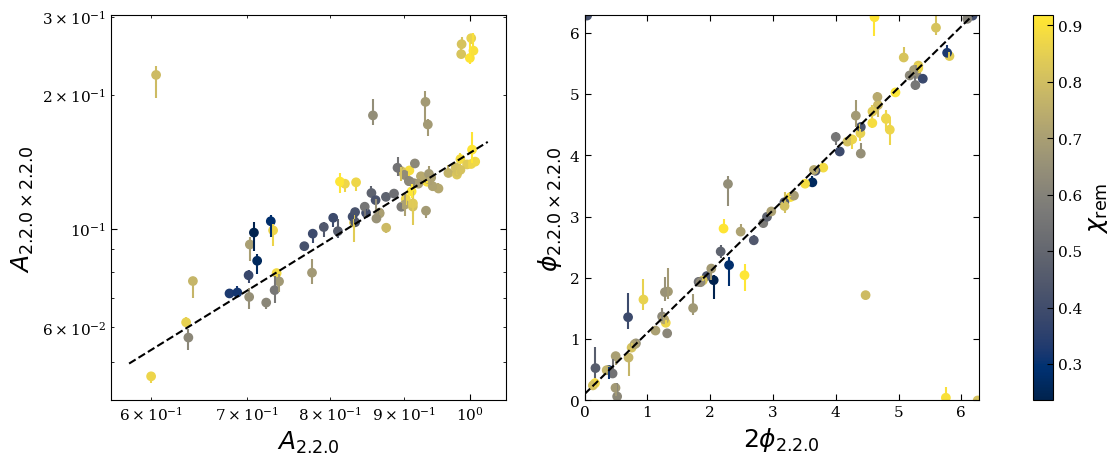

In [36]:
quad_l, quad_m = 4, 4
lin_l, lin_m = 2, 2
pro_quad_mode = "2.2.0x2.2.0"
pro_lin_mode = "2.2.0"
retro_quad_mode = qnm_string_m_reverse(pro_quad_mode)
retro_lin_mode = qnm_string_m_reverse(pro_lin_mode)

fig, axs = plt.subplots(1, 2, figsize = (14, 5))

plot_mode_vs_mode_amplitude(df, quad_l, quad_m, pro_quad_mode, retro_quad_mode,
                            lin_l, lin_m, pro_lin_mode, retro_lin_mode,
                            fit_type = "quadratic",
                            fig = fig, ax = axs[0], colorbar = False)
xsfit = np.linspace(*axs[0].get_xlim(), num = 100)
ysfit = linfunc2([-0.829738], np.log10(xsfit))
axs[0].loglog(xsfit, 10**ysfit, c = "k", ls = "--")
axs[0].plot()

sc = plot_mode_vs_mode_phase(df, quad_l, quad_m, pro_quad_mode, retro_quad_mode,
                             lin_l, lin_m, pro_lin_mode, retro_lin_mode,
                             fit_type = "quadratic",
                             fig = fig, ax = axs[1], colorbar = False, return_sc = True)
xsfit = np.linspace(0, 2*np.pi, num = 100)
ysfit = xsfit + 0.105
axs[1].plot(xsfit, ysfit, ls = "--", c = 'k')

cb = fig.colorbar(sc, ax = axs)
cb.ax.set_ylabel(r"$\chi_{\rm rem}$")

plt.savefig(PLOT_PATH + f"dependence/{settingname}_{pro_lin_mode}_{pro_quad_mode}.pdf", bbox_inches = "tight")
plt.savefig(PLOT_PATH + f"dependence/{settingname}_{pro_lin_mode}_{pro_quad_mode}.png", dpi = 150, bbox_inches = "tight",
            facecolor='white', transparent=False)

In [37]:
spheroidal_check_list = [(2, 2, 3, 0), (3, 2, 2, 0)]

1446 0.1797445262140178
1449 0.0104997153282985
1461 0.3247435333170594
1462 0.2619787032171229
1484 0.3129016027050195
1494 0.4156907034660702
233 0.389877236144012
236 0.4268508766060001
237 0.4645534520110005
241 0.526308386718
260 0.1244714960710012
261 0.2397770557600026
262 0.270613474329
264 0.2495322685770005
265 0.2566123051830005
266 0.2843549342800001
267 0.299237657077
1448 0.0125152107495962
1449 0.0104997153282985
1455 0.0212991195598697


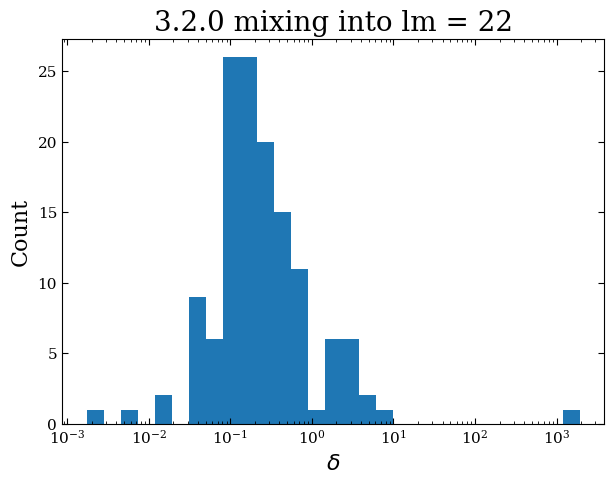

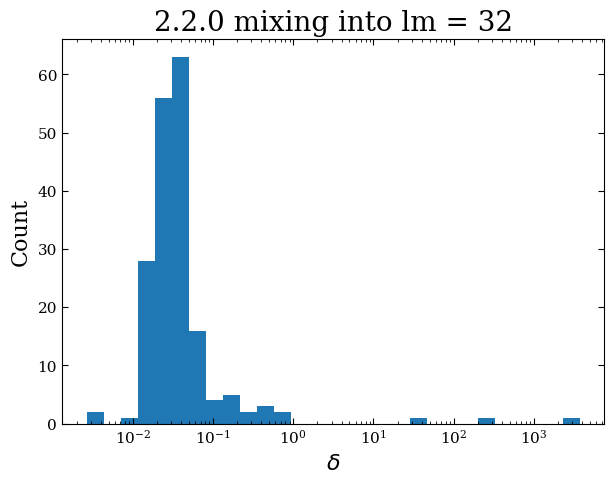

In [45]:
for l, m, l_p, n_p in spheroidal_check_list:
    mix_check_num = mixing_check_SXS_nums(df, l, m, l_p, n_p)

    ratio_err_list = []
    chi_list = []

    for SXS_num in mix_check_num:
        df_num = df[df['SXS_num'] == SXS_num]
        chi_rem = df_num['chi_rem'].values[0]
        chi_list.append(chi_rem)
        A_ratio, phi_diff = give_mixing_ratio(df_num, l, m, l_p, n_p)
        mu = ssmc_ratio(l, m, l_p, n_p, chi_rem)
        muabs = np.abs(mu)
        ratio_err = np.abs((A_ratio - muabs)/muabs)
        if ratio_err > 1:
            print(SXS_num, chi_rem)
        ratio_err_list.append(ratio_err)

    fig, ax = plt.subplots(figsize = (7,5))

    logbins = np.logspace(np.log10(min(ratio_err_list)),np.log10(max(ratio_err_list)),30)
    ax.hist(ratio_err_list, bins = logbins)
    ax.set_xscale('log')
    ax.set_xlabel("$\delta$", fontsize = 16)
    ax.set_ylabel("Count", fontsize = 16)
    ax.set_title(f"{l_p}.{m}.{n_p} mixing into lm = {l}{m}", fontsize = 20)
    plt.savefig(PLOT_PATH + f"spheroidal/{settingname}_{l}{m}_{l_p}.{m}.{n_p}.pdf", bbox_inches = "tight")
    plt.savefig(PLOT_PATH + f"spheroidal/{settingname}_{l}{m}_{l_p}.{m}.{n_p}.png", dpi = 150, bbox_inches = "tight",
            facecolor='white', transparent=False)

In [94]:
df_weak = pd.read_csv(f"./pickle/data_frame/weak.csv")
df_normal = pd.read_csv(f"./pickle/data_frame/normal.csv")
df_strong = pd.read_csv(f"./pickle/data_frame/strong.csv")

In [95]:
df_normal.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'SXS_num', 'M_rem', 'chi_rem', 'chi_1_z',
       'chi_2_z', 'q', 'l', 'm', 'retro', 'mode_string', 'A_med', 'A_hi',
       'A_low', 'phi_med', 'phi_hi', 'phi_low'],
      dtype='object')

In [171]:
df_weak_normal = df_weak.merge(df_normal, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
df_normal_strong = df_normal.merge(df_strong, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
df_weak_strong = df_weak.merge(df_strong, how = "inner",
                                on = ['SXS_num', 'M_rem',
                                      'chi_rem', 'chi_1_z',
                                      'chi_2_z', 'q', 'l', 'm', 
                                      'retro', 'mode_string'],
                              suffixes=('_1', '_2'))
                              

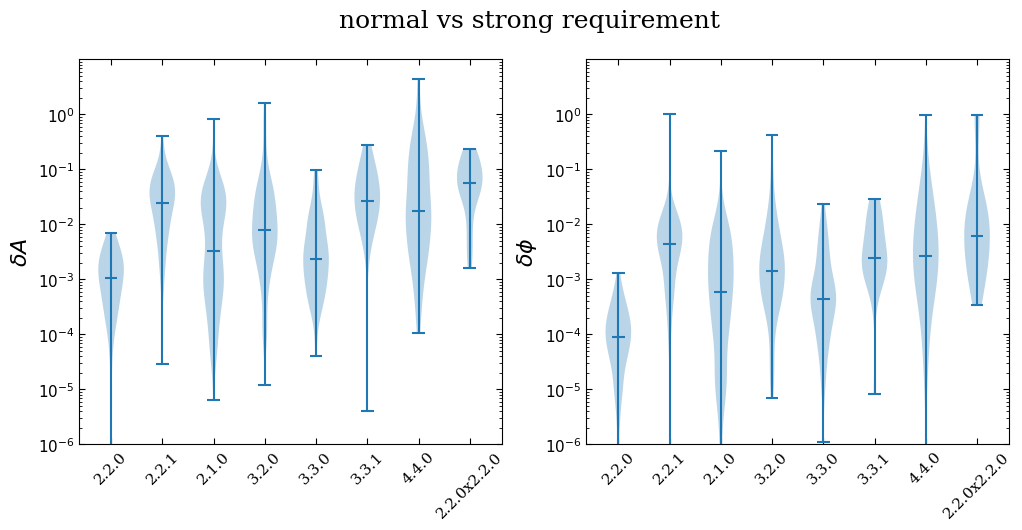

In [207]:
setting_low = "normal"
setting_hi = "strong"

if setting_low == 'weak' and setting_hi == 'strong':
    df_in = df_weak_strong
elif setting_low == 'weak' and setting_hi == 'normal':
    df_in = df_weak_normal
elif setting_low == 'normal' and setting_hi == 'strong':
    df_in = df_normal_strong
else:
    raise ValueError

compare_list = [(2, 2, '2.2.0'), (2, 2, '2.2.1'), 
                (2, 1, '2.1.0'), (3, 2, '3.2.0'),
                (3, 3, "3.3.0"), (3, 3, '3.3.1'),
                (4, 4, "4.4.0"), 
                (4, 4, "2.2.0x2.2.0")]

fig, axs = plt.subplots(1,2, figsize = (12, 5))

ds_A = []
ds_phi = []
mode_strings = []

for l, m, pro_mode_string in compare_list:

    retro_mode_string = qnm_string_m_reverse(pro_mode_string)

    df_compare = df_in[((df_in['l'] == l) & (df_in['m'] == m) & (df_in['mode_string'] == pro_mode_string)
                        & (df_in['retro'] == False)) |
                        ((df_in['l'] == l) & (df_in['m'] == m) & (df_in['mode_string'] == retro_mode_string)
                        & (df_in['retro'] == True))  ]

    A_1 = df_compare['A_med_1'].to_numpy()
    A_2 = df_compare['A_med_2'].to_numpy()
    phi_1 = df_compare['phi_med_1'].to_numpy()    
    phi_2 = df_compare['phi_med_2'].to_numpy()
    
    A_delta = np.abs((A_2 - A_1)/A_1)
    A_delta_nonzero = A_delta[A_delta != 0]
    phi_delta = np.minimum(np.abs((phi_2%(2*np.pi) - phi_1%(2*np.pi))/(2*np.pi)),
                    (2*np.pi - np.abs((phi_2%(2*np.pi) - phi_1%(2*np.pi)))/(2*np.pi)))
    phi_delta_nonzero = phi_delta[phi_delta != 0]

    ds_A.append(np.log10(A_delta_nonzero))
    ds_phi.append(np.log10(phi_delta_nonzero))
    mode_strings.append(pro_mode_string)

    # ax.scatter([pro_mode_string] * len(A_delta_nonzero), A_delta_nonzero, alpha = 0.1)
axs[0].violinplot(ds_A, showextrema=True, showmedians=True, points = 100)
axs[1].violinplot(ds_phi, showextrema=True, showmedians=True, points = 100)

for ax in axs:
    ax.set_ylim(-6, 1)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
    ymin, ymax = ax.get_ylim()
    tick_range = np.arange(np.floor(ymin), ymax)
    ax.yaxis.set_ticks(tick_range)
    ax.yaxis.set_ticks([np.log10(x) for p in tick_range for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)

    ax.set_xticks(list(range(1, len(compare_list) + 1)))
    ax.set_xticklabels(mode_strings)
    ax.tick_params('x', rotation = 45)
axs[0].set_ylabel("$\delta A$", fontsize = 16)
axs[1].set_ylabel("$\delta \phi$", fontsize = 16)
fig.suptitle(f"{setting_low} vs {setting_hi} requirement", fontsize = 18)
plt.savefig(PLOT_PATH_ROOT + f"{setting_low}_vs_{setting_hi}.pdf", bbox_inches = "tight")
plt.savefig(PLOT_PATH_ROOT + f"{setting_low}_vs_{setting_hi}.png", dpi = 150, bbox_inches = "tight",
        facecolor='white', transparent=False)